# Finding publisher signatures with logistic regression

#### Dependencies

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re

%matplotlib inline

%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from datatasks.sample_data import sample_data
from models.feature_spaces import create_tfidf
from models.pipeline import make_features_pipeline
%aimport models.pipeline
from models.models import run_models
from models.EDA import get_most_important_features
from models.plot import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv')
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv')

In [3]:
train_s = sample_data(train, 50000, 'train')
val_s = sample_data(val, 10000, 'val')

In [4]:
transformer = create_tfidf()
feats = make_features_pipeline(transformer, 'preprocessed_text', custom_features=False)

In [50]:
#X_train = train_s[~(train_s['domain'].isin(['foxbusiness', 'abqjournal']))]
#X_train = X_train.drop('hyperpartisan', axis=1)
#y_train = X_train['hyperpartisan']

X_train = train_s.drop('hyperpartisan', axis=1)
y_train = train_s['hyperpartisan'].tolist()

X_test = val_s.drop('hyperpartisan', axis=1)
y_test = val_s['hyperpartisan'].tolist()

In [51]:
best_tfidf_model, best_tfidf_model_type, best_tfidf_model_predictions = run_models(feats, ['lr'], X_train, X_test, y_train, y_test)

Logistic Regression
             precision    recall  f1-score   support

      False       0.67      0.45      0.54      4999
       True       0.59      0.78      0.67      5000

avg / total       0.63      0.62      0.61      9999

Accuracy: 0.6175
Best model is Logistic Regression with an accuracy score of 0.6175


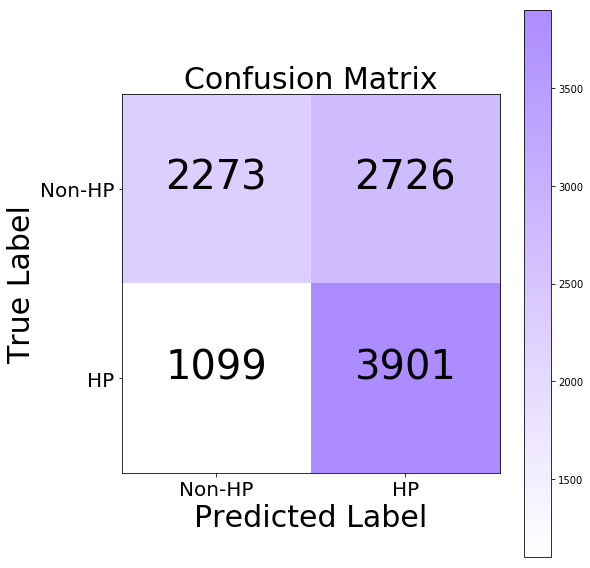

In [52]:
plot_confusion_matrix(y_test, best_tfidf_model_predictions)

In [8]:
transformer.fit_transform(X_train['preprocessed_text'])

<49997x381196 sparse matrix of type '<class 'numpy.float64'>'
	with 14916183 stored elements in Compressed Sparse Row format>

In [9]:
features = get_most_important_features(transformer, best_tfidf_model, n=10)

In [10]:
for i in range(len(features[0]['bottom'])):
    print(features[0]['bottom'][i][1])

embedded
aug
parry
jan
albuquerque
blade
ap
upi
advertisement
globalpost


In [11]:
base_props = train['domain'].value_counts(normalize=True)

In [12]:
for i in range(5): #len(features[0]['tops'][0])):
    feature = str(features[0]['bottom'][i][1])
    print(feature)
    props = train[train['preprocessed_text'].str.contains(" {} ".format(feature), regex=False)]['domain'].value_counts(normalize=True)
    for key in props.keys():
        if props[key] > 2*base_props[key]:
            print(key, "- Observed: {:.3f}, Expected: {:.3f}, Difference: {:.3f}".format(props[key], base_props[key], props[key]/base_props[key]))
            
            # Examine context of term
            
    print("\n")

embedded
counterpunch - Observed: 0.199, Expected: 0.056, Difference: 3.572
consortiumnews - Observed: 0.030, Expected: 0.010, Difference: 2.988
dissentmagazine - Observed: 0.021, Expected: 0.008, Difference: 2.530
eppc - Observed: 0.021, Expected: 0.006, Difference: 3.422
21stcenturywire - Observed: 0.018, Expected: 0.003, Difference: 6.935
foreignpolicyjournal - Observed: 0.013, Expected: 0.004, Difference: 3.735
inthesetimes - Observed: 0.013, Expected: 0.004, Difference: 3.664
jacobinmag - Observed: 0.013, Expected: 0.002, Difference: 5.263
legalinsurrection - Observed: 0.012, Expected: 0.003, Difference: 3.566
mintpressnews - Observed: 0.012, Expected: 0.006, Difference: 2.019
intrepidreport - Observed: 0.011, Expected: 0.004, Difference: 3.170
billmoyers - Observed: 0.009, Expected: 0.004, Difference: 2.094
alternet - Observed: 0.007, Expected: 0.002, Difference: 2.911
newpol - Observed: 0.004, Expected: 0.000, Difference: 8.824
democracyjournal - Observed: 0.002, Expected: 0.000

In [135]:
domain = 'thedailybeast'
obs = train[(train['preprocessed_text'].str.contains(' speedy ')) &
           (train['domain']==domain)].reset_index()

In [127]:
obs.shape

(4, 17)

In [128]:
train[train['domain']==domain].shape

(72, 16)

In [137]:
from difflib import SequenceMatcher

s1 = obs['preprocessed_text'][0]
s2 = obs['preprocessed_text'][1]

match = SequenceMatcher(None, s1, s2).find_longest_match(0, len(s1), 0, len(s2))

In [143]:
match

Match(a=3366, b=4925, size=6)

In [242]:
def find_common_windows(term, domain, df):
    
    series = df[(df['preprocessed_text'].str.contains(' {} '.format(term))) &
           (df['domain']==domain)].reset_index()['preprocessed_text']
    
    common_windows = {}
    
    if bool(common_windows) == False:
        s1 = series[0]
        s2 = series[1]
        
        longest_window = find_widest_common_window(term, s1, s2)
        
        common_windows[longest_window] = 0
        
    for text in series:
        if window in text:
            common_windows[window] += 1
            
    return common_windows

def find_widest_common_window(term, s1, s2):
    
    # split two articles by spaces
    text_split_1 = s1.split(' ')
    text_split_2 = s2.split(' ')

    # Get indices of all appearances of target term
    i_1 = [i for i,x in enumerate(text_split_1) if x == term]
    i_2 = [i for i,x in enumerate(text_split_2) if x == term]

    # iterate over inidices in first
    longest_match = [term]

    # initialize distances
    f_distance = 1
    b_distance = 1

    for i in i_1:

        while True:

            # get word ahead of and behind target word for each time it shows up
            word_ahead = text_split_1[i+f_distance]
            word_behind = text_split_1[i-b_distance]

            for j in i_2:

                # if there is a forward or backward match, append/insert and increase respective distance. else remove.
                if text_split_2[j+f_distance] == word_ahead:
                    longest_match.append(word_ahead)
                    f_distance += 1
                elif text_split_2[j-b_distance] == word_behind:
                    longest_match.insert(0,word_behind)
                    b_distance += 1
                else:
                    i_2.remove(j)

            # break when matches are no longer found
            if len(i_2) == 0:
                break
                
    return " ".join(longest_match)

In [13]:
def find_common_context_windows(term, domain, df, df_text_col, window):
    
    series = df[(df['preprocessed_text'].str.contains(' {} '.format(term))) &
           (df['domain']==domain)].reset_index()[df_text_col]
    
    context = []
    
    for text in series:
        text_split = text.split(' ')
        
        indices = [i for i,x in enumerate(text_split) if x == term]
        
        for index in indices:
            context.append([catch(lambda: text_split[index+i]) for i in range(-window, window+1)])
            
    return context

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return 'OOR'

In [14]:
term = 'albuquerque'
domain = 'abqjournal'
context = find_common_context_windows(term, domain, train, 'preprocessed_text', 3)

In [25]:
con = pd.DataFrame(context)
for c in con.columns:
    print(con[c].value_counts().head(4))

the         2219
appeared    1675
a1          1100
c1           879
Name: 0, dtype: int64
of     6443
in     3581
at     1246
the    1048
Name: 1, dtype: int64
the    13778
in      9479
of      3926
to      1906
Name: 2, dtype: int64
albuquerque    50749
Name: 3, dtype: int64
journal    8358
police     3313
and        2293
public     1077
Name: 4, dtype: int64
OOR           4818
it            1775
department    1669
the           1614
Name: 5, dtype: int64
OOR    5254
was    2028
the    1886
a      1060
Name: 6, dtype: int64


In [73]:
con[con[0]=='a1']

,0,1,2,3,4,5,6
9,a1,of,the,albuquerque,journal,OOR,OOR
58,a1,of,the,albuquerque,journal,OOR,OOR
67,a1,of,the,albuquerque,journal,OOR,OOR
86,a1,of,the,albuquerque,journal,OOR,OOR
103,a1,of,the,albuquerque,journal,OOR,OOR
125,a1,of,the,albuquerque,journal,OOR,OOR
138,a1,of,the,albuquerque,journal,OOR,OOR
175,a1,of,the,albuquerque,journal,OOR,OOR
206,a1,of,the,albuquerque,journal,OOR,OOR
217,a1,of,the,albuquerque,journal,OOR,OOR


In [27]:
obs = train[(train['preprocessed_text'].str.contains(' {} '.format('appeared on page'))) & (train['domain']==domain)].reset_index()['preprocessed_text']

In [28]:
obs.shape

(5274,)

In [48]:
def remove_stuff(article):
    
    text = article['preprocessed_text']
    
    text = re.sub(r' advertisement ', '', text)
    
    if article['domain'] == 'foxbusiness':
        text = re.sub(r' continue reading below ', '', text)
        
    if article['domain'] == 'abqjournal':
        text = re.sub(r' albuquerque ', '', text)
        
    article['preprocessed_text'] = text
        
    return article

In [49]:
train_s = train_s.apply(remove_stuff, axis=1)

In [57]:
preds = pd.DataFrame(list(zip(best_tfidf_model_predictions, y_test)), columns=['y_hat', 'y'])

In [72]:
val_s.iloc[preds[~(preds['y_hat'] == preds['y'])].index,:]['preprocessed_text']

0       advice for hezbollah how to win over the prowe...
1       kathy griffin tells jesus to suck it comedian ...
2       did president donald trump amend an executive ...
3       tea party purges and departures \n \nhistory r...
6       obamas remarks on gay rights \n \n \nremarks b...
7       the war against planned parenthood guest voice...
9       the incredibility of curveball \n curveball th...
11      guest voice troop surge resolution \n note the...
13      carly fiorina endorses ted cruz \n us sen ted ...
14      the olympic games and the us elections bad tim...
15      why i now feel sorry for george w bush \n perh...
16      with barack obama democrats find answer to the...
17      wait an hour after eating to swim will swimmin...
18      can obama be luke skywalker \n washington welc...
19      walmart vs the morons email provides statistic...
20      gallup poll bush sets new approval rating low ...
22      reminders from japan \n while the disaster in ...
25      key ke

In [68]:
best_tfidf_model

LogisticRegression(C=30.0, class_weight='None', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)